In [1]:
from multiprocessing import cpu_count
  
print("CPU的核数为：{}".format(cpu_count()))

! nvidia-smi

CPU的核数为：16
Thu Jun 15 17:21:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:0A.0 Off |                    0 |
| N/A   28C    P0    31W / 250W |   6645MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:00:0B.0 Off |                    0

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, confusion_matrix, f1_score, accuracy_score, recall_score, classification_report, roc_auc_score, auc, roc_curve
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

# 1 读取数据
## 训练集数据读取

In [4]:
data1_1 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/acc_tiny_1.pkl')
data1_2 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/mag_tiny_1.pkl')
data1_3 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/gyr_tiny_1.pkl')
label1 = pd.read_pickle('/home/ossdata/dengjiebi/data_tiny/train/label.pkl')

In [5]:
data1=pd.concat([data1_1, data1_2,data1_3],axis=1)

In [6]:
data1.head(5)

,Acc_x,Acc_y,Acc_z,L2_ACC,Mean_Acc_x,Mean_Acc_y,Mean_Acc_z,Mean_L2_ACC,Var_Acc_x,Var_Acc_y,...,Gyr_z,L2_GYR,Mean_Gyr_x,Mean_Gyr_y,Mean_Gyr_z,Mean_L2_GYR,Var_Gyr_x,Var_Gyr_y,Var_Gyr_z,Var_L2_GYR
0,9.299079,-0.536301,-3.916914,10.104588,8.884207,-1.796277,1.521092,10.590318,12.278721,6.535145,...,0.0,0.000887,-0.205098,-0.062477,0.037869,0.796943,0.983457,0.286849,0.215368,0.877692
1,9.293343,-0.536301,-3.924570,10.102282,8.783531,-1.702502,1.617708,10.487590,12.183634,6.589913,...,0.0,0.001305,-0.195681,-0.043004,0.057586,0.798641,0.953424,0.289042,0.220241,0.848525
2,9.306733,-0.524802,-3.909260,10.108067,8.611817,-1.653310,1.957650,10.563665,12.734154,6.454772,...,0.0,0.001728,-0.158274,-0.050421,0.082096,0.815494,0.967446,0.281478,0.232360,0.830242
3,9.299079,-0.528867,-3.914771,10.103366,8.487783,-1.546218,2.174076,10.556660,12.843903,6.631528,...,0.0,0.000891,-0.142143,-0.022361,0.076890,0.819762,0.945800,0.298666,0.225993,0.804898
4,9.291411,-0.526724,-3.930341,10.102244,8.480158,-1.472115,2.297583,10.553625,12.456671,6.617274,...,0.0,0.001222,-0.136152,-0.010978,0.068639,0.808068,0.918360,0.294020,0.221459,0.785156


In [7]:
X=data1
y=label1['label']

## 验证集数据读取

In [8]:
data2_1 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate_acc_tiny_1.pkl')
data2_2 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate_mag_tiny_1.pkl')
data2_3 = pd.read_pickle('/home/ossdata/dengjiebi/data_full/validate_gyr_tiny_1.pkl')
label2 = pd.read_pickle('/home/ossdata/dengjiebi/data_tiny/validate/label.pkl')

In [9]:
data2=pd.concat([data2_1, data2_2,data2_3],axis=1)

In [10]:
X_val=data2
y_val=label2['label']

# 特征工程
由于XGBClassifier在训练过程对类别标签的要求是必须从 0 开始，而原始数据集的标签从1开始，所以需要`sklearn`库中的`LabelEncoder()`函数将标签转化为相对应的格式。

In [12]:
le = LabelEncoder()
y = le.fit_transform(y)
y_val = le.fit_transform(y_val)

In [13]:
#查看标签转化结果
le.inverse_transform([0,1,2,3,4,5,6,7])

array([1, 2, 3, 4, 5, 6, 7, 8])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 建立模型

In [17]:
model_XGB_final = xgb.XGBClassifier(learning_rate=0.01,
                                    n_estimators=200,
                                    gpu_id=0,
                                    max_depth=5,
                                    min_child_weight=1,
                                    gamma=0,
                                    tree_method='gpu_hist')


In [18]:
model_XGB_final.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

# 模型评价

In [19]:
label_dic = {0: 'Still', 1: 'Walking', 2: 'Run', 3: 'Bike', 4: 'Car', 5: 'Bus', 6: 'Train', 7: 'Subway'}

In [20]:
def evaluate(y_true, y_pred, class_names = list(label_dic.values())):
    conf = confusion_matrix(y_true , y_pred)
    print(conf)
    plt.figure(figsize=(9,8))
    sns.heatmap(conf,cmap=plt.cm.Blues, annot=True, fmt="d")
    plt.xlabel('Predict label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix',fontsize=16)
    print(classification_report(y_true, y_pred, target_names = class_names))

In [21]:
y_val_pred = model_XGB_final.predict(X_val).tolist()

[[21837   834    21   195   597  3225  2613   519]
 [  181 16781    48  8085   385   539   120     9]
 [    0  1036  1739     0     0     0     0     0]
 [   12  1656     0  4368  4944  1010    39     0]
 [  325    46    22    55 13429  5572   690   335]
 [  347   244     0   320  4086  3879   170   131]
 [  915   282     0    74   109  1039 17528  1863]
 [  143   120     0    95   368    32 13274  7674]]
              precision    recall  f1-score   support

       Still       0.92      0.73      0.81     29841
     Walking       0.80      0.64      0.71     26148
         Run       0.95      0.63      0.76      2775
        Bike       0.33      0.36      0.35     12029
         Car       0.56      0.66      0.61     20474
         Bus       0.25      0.42      0.32      9177
       Train       0.51      0.80      0.62     21810
      Subway       0.73      0.35      0.48     21706

    accuracy                           0.61    143960
   macro avg       0.63      0.57      0.58    14

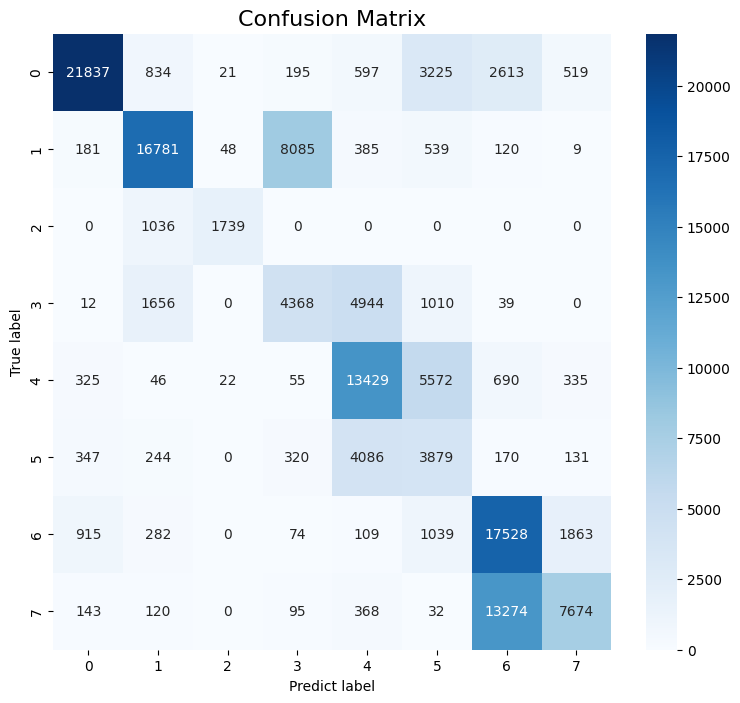

In [23]:
evaluate(y_val, y_val_pred)

In [24]:
f1_score(y_val, y_val_pred, average='macro')

0.5812131758622898

# 模型平滑

In [31]:
label2['label_pred']=y_val_pred
label2['time']=pd.to_datetime(label2['time'], unit="ms")
label2.set_index(keys='time',inplace=True)
label2

,label,label_pred
time,,
2017-06-14 08:04:51.760,3,2
2017-06-14 08:04:52.760,3,2
2017-06-14 08:04:53.760,3,2
2017-06-14 08:04:54.760,3,2
2017-06-14 08:04:55.760,3,2
...,...,...
2017-07-18 15:00:28.760,1,6
2017-07-18 15:00:29.760,1,6
2017-07-18 15:00:30.760,1,6


In [30]:
label2.reset_index(inplace=True)
label2['time']=label2.time.values.astype('int') // 10**6

In [39]:
label2['pred_mode_60s'] = label2['label_pred'].rolling('60s', center = True).agg(lambda x: x.mode()[0]).fillna(method = 'ffill').fillna(method = 'bfill').astype('int')
label2['pred_mode_120s'] = label2['label_pred'].rolling('120s', center = True).agg(lambda x: x.mode()[0]).fillna(method = 'ffill').fillna(method = 'bfill').astype('int')
label2['pred_mode_300s'] = label2['label_pred'].rolling('300s', center = True).agg(lambda x: x.mode()[0]).fillna(method = 'ffill').fillna(method = 'bfill').astype('int')

In [43]:
label2['label_diff']=label2['label_pred']-label2['pred_mode_60s']
print('60s众数平滑窗口改变的标签量为：{}'.format(len(label2[label2['label_diff']!=0])))
label2['label_diff']=label2['label_pred']-label2['pred_mode_120s']
print('12s众数平滑窗口改变的标签量为：{}'.format(len(label2[label2['label_diff']!=0])))
label2['label_diff']=label2['label_pred']-label2['pred_mode_300s']
print('300s众数平滑窗口改变的标签量为：{}'.format(len(label2[label2['label_diff']!=0])))

60s众数平滑窗口改变的标签量为：9179
12s众数平滑窗口改变的标签量为：16194
300s众数平滑窗口改变的标签量为：22956


In [ ]:
label2.reset_index(inplace=True)
label2

In [49]:
label0=pd.read_pickle('/home/ossdata/dengjiebi/data_processed/validate/label.pkl')
label0['time']=pd.to_datetime(label0['time'], unit="ms")
label0

,time,label
0,2017-06-14 08:04:51.760,3
1,2017-06-14 08:04:51.770,3
2,2017-06-14 08:04:51.780,3
3,2017-06-14 08:04:51.790,3
4,2017-06-14 08:04:51.800,3
...,...,...
14395936,2017-07-18 15:00:33.120,1
14395937,2017-07-18 15:00:33.130,1
14395938,2017-07-18 15:00:33.140,1
14395939,2017-07-18 15:00:33.150,1


In [52]:
df_full=pd.merge_asof(label0,label2[['time','label_pred','pred_mode_60s','pred_mode_120s','pred_mode_300s']],on='time', tolerance=pd.Timedelta("1s"),direction='nearest')
df_full['label_pred']+=1
df_full['pred_mode_60s']+=1
df_full['pred_mode_120s']+=1
df_full['pred_mode_300s']+=1
df_full

,time,label,label_pred,pred_mode_60s,pred_mode_120s,pred_mode_300s
0,2017-06-14 08:04:51.760,3,3,3,3,3
1,2017-06-14 08:04:51.770,3,3,3,3,3
2,2017-06-14 08:04:51.780,3,3,3,3,3
3,2017-06-14 08:04:51.790,3,3,3,3,3
4,2017-06-14 08:04:51.800,3,3,3,3,3
...,...,...,...,...,...,...
14395936,2017-07-18 15:00:33.120,1,7,7,7,1
14395937,2017-07-18 15:00:33.130,1,7,7,7,1
14395938,2017-07-18 15:00:33.140,1,7,7,7,1
14395939,2017-07-18 15:00:33.150,1,7,7,7,1


[[2183672   83356    2137   19458   59709  322333  261153   51934]
 [  18100 1678165    4853  808342   38463   54001   12041     889]
 [      0  103590  173798       0       0       0       0       0]
 [   1225  165609       0  436881  494400  100955    3980       0]
 [  32467    4601    2163    5526 1342928  557200   68974   33511]
 [  34723   24448       0   32032  408600  387911   16994   13100]
 [  91500   28220       0    7390   10900  103940 1752787  186255]
 [  14307   12060       0    9527   36800    3200 1327429  767404]]
              precision    recall  f1-score   support

       Still       0.92      0.73      0.81   2983752
     Walking       0.80      0.64      0.71   2614854
         Run       0.95      0.63      0.76    277388
        Bike       0.33      0.36      0.35   1203050
         Car       0.56      0.66      0.61   2047370
         Bus       0.25      0.42      0.32    917808
       Train       0.51      0.80      0.62   2180992
      Subway       0.73      0

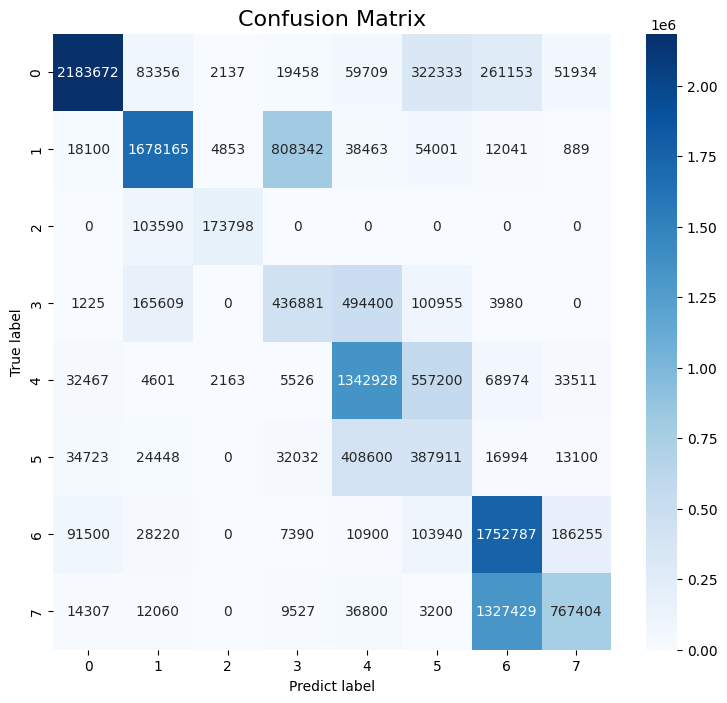

In [53]:
evaluate(df_full['label'],df_full['label_pred'])
print('macro F1 score:{}'.format(f1_score(df_full['label'],df_full['label_pred'], average='macro')))

[[2225989   79791    1537   17801   46409  311905  250748   49572]
 [  11600 1716048    3653  809237   23063   43100    8153       0]
 [      0  101592  175796       0       0       0       0       0]
 [    925  160509       0  456081  498800   83755    2980       0]
 [  32944    4238    2063    3110 1358582  556100   60922   29411]
 [  31300   25371       0   29718  434523  379457    9139    8300]
 [  79109   29319       0    4200    4500   83840 1832769  147255]
 [   5100    6011       0    5402   24684       0 1394825  734705]]
              precision    recall  f1-score   support

       Still       0.93      0.75      0.83   2983752
     Walking       0.81      0.66      0.72   2614854
         Run       0.96      0.63      0.76    277388
        Bike       0.34      0.38      0.36   1203050
         Car       0.57      0.66      0.61   2047370
         Bus       0.26      0.41      0.32    917808
       Train       0.51      0.84      0.64   2180992
      Subway       0.76      0

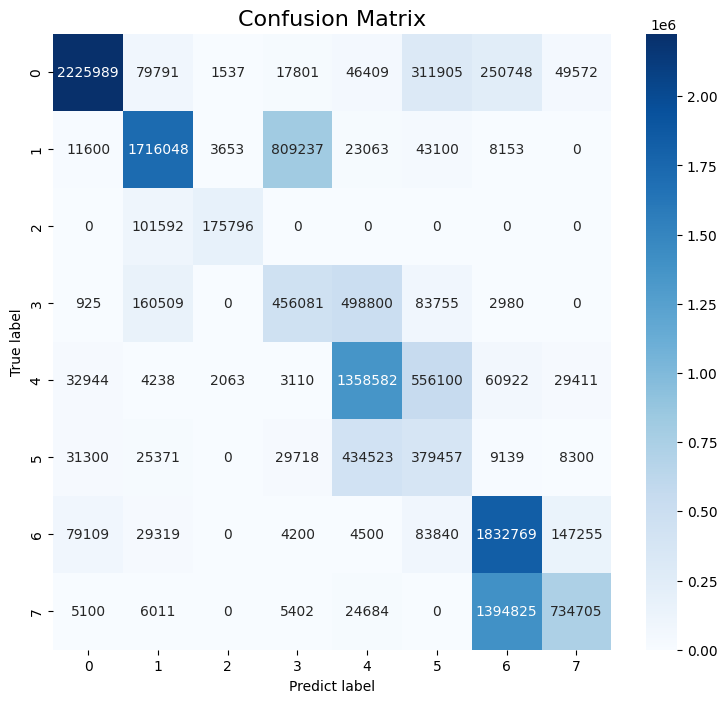

In [54]:
evaluate(df_full['label'],df_full['pred_mode_60s'])
print('macro F1 score:{}'.format(f1_score(df_full['label'],df_full['pred_mode_60s'], average='macro')))

[[2286691   81299       0    6139   41000  308724  213765   46134]
 [   5400 1732497    2653  819315    6900   48000      89       0]
 [      0  111392  165996       0       0       0       0       0]
 [   1325  145709       0  472417  519800   60755    3044       0]
 [  28900    2438       0     731 1370016  573859   52359   19067]
 [  16900   23382       0   24507  459423  384657    8939       0]
 [  75909   28257       0       0       0   70026 1898123  108677]
 [   1000    2693       0     727   11100       0 1448064  707143]]
              precision    recall  f1-score   support

       Still       0.95      0.77      0.85   2983752
     Walking       0.81      0.66      0.73   2614854
         Run       0.98      0.60      0.74    277388
        Bike       0.36      0.39      0.37   1203050
         Car       0.57      0.67      0.61   2047370
         Bus       0.27      0.42      0.33    917808
       Train       0.52      0.87      0.65   2180992
      Subway       0.80      0

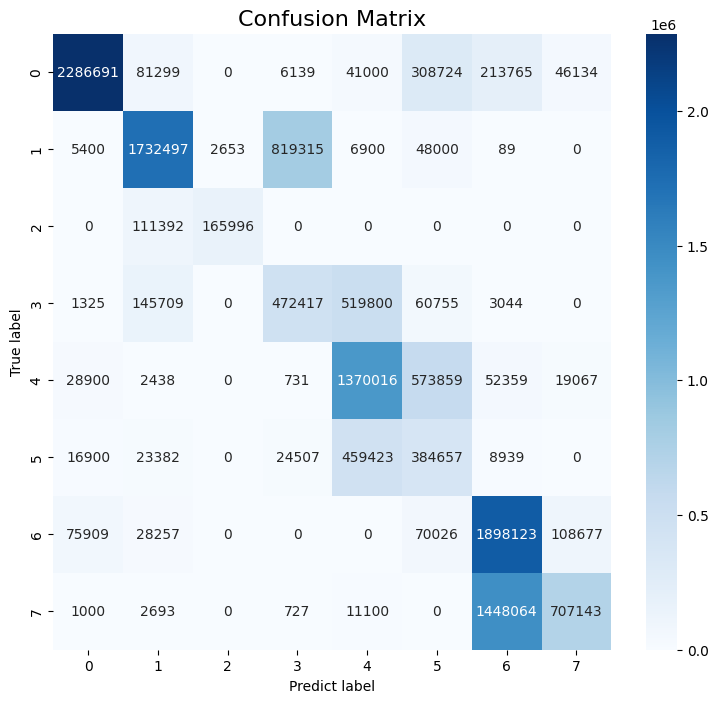

In [55]:
evaluate(df_full['label'],df_full['pred_mode_120s'])
print('macro F1 score:{}'.format(f1_score(df_full['label'],df_full['pred_mode_120s'], average='macro')))

[[2364276   80835       0   12824   38756  265359  192902   28800]
 [   6124 1734768    2653  841774       0   26499    3036       0]
 [      0   98592  178796       0       0       0       0       0]
 [    625  146028       0  470036  557780   28581       0       0]
 [  25100       0       0    4331 1370775  621259   21938    3967]
 [      0   19228       0   14043  484324  400213       0       0]
 [  62126   28457       0    3709       0   37288 2017223   32189]
 [      0    5493       0       0       0       0 1482008  683226]]
              precision    recall  f1-score   support

       Still       0.96      0.79      0.87   2983752
     Walking       0.82      0.66      0.73   2614854
         Run       0.99      0.64      0.78    277388
        Bike       0.35      0.39      0.37   1203050
         Car       0.56      0.67      0.61   2047370
         Bus       0.29      0.44      0.35    917808
       Train       0.54      0.92      0.68   2180992
      Subway       0.91      0

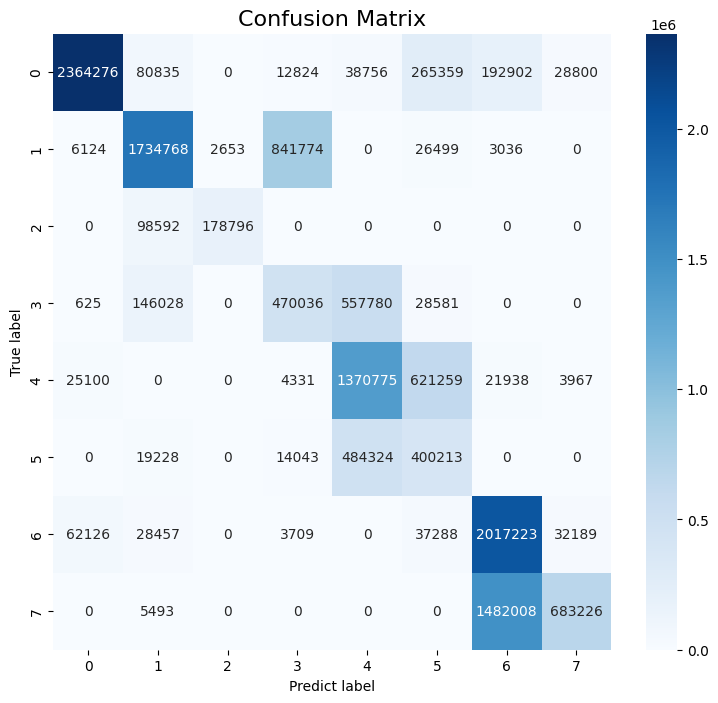

In [56]:
evaluate(df_full['label'],df_full['pred_mode_300s'])
print('macro F1 score:{}'.format(f1_score(df_full['label'],df_full['pred_mode_300s'], average='macro')))